In [1]:
import os
from google.colab import drive
 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd '/content/gdrive/My Drive/Kaggle'

/content/gdrive/My Drive/Kaggle


In [3]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [4]:
#Reading only the title of the review and the rating
data1 = pd.read_csv('Amazon.csv',usecols=['reviews.title','reviews.rating'])

In [5]:
data1.head(2)

,reviews.rating,reviews.title
0,3,... 3 of them and one of the item is bad quali...
1,4,... always the less expensive way to go for pr...


In [6]:
#Making a connection to the database
conn = sqlite3.connect('database.sqlite')

#Selecting the only the Text and rating from the reviews
data2 = pd.read_sql_query('''SELECT Text ,Score FROM Reviews WHERE Score !=3  ORDER BY RANDOM() LIMIT 80000''',conn)

In [7]:
data2

,Text,Score
0,Bought 1/2 lb each of five different Mo's Fudg...,5
1,I purchased this coffee after not being able t...,4
2,This stuff is delicious. Highly recommend you ...,5
3,I bought this spinner with the best of intenti...,5
4,Looks like they didn't really taste test this ...,2
...,...,...
79995,"I spent 3+ decades of my life in Japan, and I ...",5
79996,This appears smaller than it is because it is ...,5
79997,These bars have big time peanut flavor. Incor...,4
79998,I don't eat enough fruits and vegetables. Thi...,5


In [8]:
data1.shape

(28332, 2)

In [9]:
data2.shape

(80000, 2)

In [10]:
#Catogarizing the scores as 1 and 0 with the assumption that if the score is above 3 it is positive else negative
def pos_neg(x):
  if x > 3 :
    return 1
  else:
    return 0

In [11]:
data1 = data1[['reviews.title','reviews.rating']]

In [12]:
data1

,reviews.title,reviews.rating
0,... 3 of them and one of the item is bad quali...,3
1,... always the less expensive way to go for pr...,4
2,... are not Duracell but for the price i am ha...,5
3,... as well as name brand batteries at a much ...,5
4,... batteries are very long lasting the price ...,5
...,...,...
28327,Xmas gift,5
28328,yes it is a great tablet.,4
28329,You get a lot for the price!,5
28330,You get the entire World for less than $100!,5


In [13]:
data1.columns = ['Text','Score']

In [14]:
#Not selecting score == 3  since it is sort of neutral rating
data1 = data1[data1['Score'] != 3]
data1.shape

(27126, 2)

In [15]:
data1

,Text,Score
1,... always the less expensive way to go for pr...,4
2,... are not Duracell but for the price i am ha...,5
3,... as well as name brand batteries at a much ...,5
4,... batteries are very long lasting the price ...,5
5,... batteries for Christmas and the AmazonBasi...,5
...,...,...
28327,Xmas gift,5
28328,yes it is a great tablet.,4
28329,You get a lot for the price!,5
28330,You get the entire World for less than $100!,5


In [16]:
data2 = data2[['Text','Score']]
data2

,Text,Score
0,Bought 1/2 lb each of five different Mo's Fudg...,5
1,I purchased this coffee after not being able t...,4
2,This stuff is delicious. Highly recommend you ...,5
3,I bought this spinner with the best of intenti...,5
4,Looks like they didn't really taste test this ...,2
...,...,...
79995,"I spent 3+ decades of my life in Japan, and I ...",5
79996,This appears smaller than it is because it is ...,5
79997,These bars have big time peanut flavor. Incor...,4
79998,I don't eat enough fruits and vegetables. Thi...,5


In [17]:
#Merging data1 and data2 to obtain the combined dataframe
data_merged = data1.append(data2,ignore_index=True)

In [18]:
data_merged

,Text,Score
0,... always the less expensive way to go for pr...,4
1,... are not Duracell but for the price i am ha...,5
2,... as well as name brand batteries at a much ...,5
3,... batteries are very long lasting the price ...,5
4,... batteries for Christmas and the AmazonBasi...,5
...,...,...
107121,"I spent 3+ decades of my life in Japan, and I ...",5
107122,This appears smaller than it is because it is ...,5
107123,These bars have big time peanut flavor. Incor...,4
107124,I don't eat enough fruits and vegetables. Thi...,5


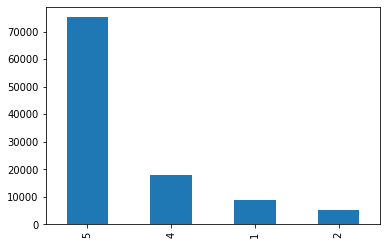

In [19]:
#Finding the ratings of values
data_merged['Score'].value_counts().plot(kind='bar')

In [20]:
#Categorizing the datas as postive and negative 
data_merged['Score'] = data_merged['Score'].apply(pos_neg)

In [21]:
data_merged

,Text,Score
0,... always the less expensive way to go for pr...,1
1,... are not Duracell but for the price i am ha...,1
2,... as well as name brand batteries at a much ...,1
3,... batteries are very long lasting the price ...,1
4,... batteries for Christmas and the AmazonBasi...,1
...,...,...
107121,"I spent 3+ decades of my life in Japan, and I ...",1
107122,This appears smaller than it is because it is ...,1
107123,These bars have big time peanut flavor. Incor...,1
107124,I don't eat enough fruits and vegetables. Thi...,1


In [22]:
data_merged['Score'].value_counts()

1    93035
0    14091
Name: Score, dtype: int64

## UnderSampling the Positive class to avoid imbalanced dataset

In [23]:
pos = data_merged[data_merged['Score'] == 1] 
neg = data_merged[data_merged['Score'] == 0] 

In [24]:
pos = pos.sample(neg.shape[0])

In [25]:
print(pos.shape)
print(neg.shape)

(14091, 2)
(14091, 2)


In [26]:
data_sampled = pos.append(neg,ignore_index=True)

In [27]:
data_sampled

,Text,Score
0,What a wonderful taste these little pods have....,1
1,Nice Tablet for kids,1
2,This soup is really quite tasty. It is lower ...,1
3,good stuff. nothing like butter chicken you wo...,1
4,"I basically gave up ""flavored"" coffee years ag...",1
...,...,...
28177,"First, a bunch of us tried this product, but r...",0
28178,I love green mountain coffee and most flavored...,0
28179,The item displayed here is raw hulled sunflowe...,0
28180,We don't like these at all. I think the mix h...,0


In [28]:
##Checking if there are any null values
data_sampled.isnull().mean()

Text     0.0
Score    0.0
dtype: float64

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
stop_words.remove('very')
stop_words.remove('not')
stop_words.remove("isn't")
stop_words.remove("doesn't")
stop_words.remove("too")
stop_words.remove('most')

In [31]:
## Cleaning the punctuations , numbers , stopwords and  doing stemming
cleaned_text = []
for i in range(0,len(data_sampled)):
   text = re.sub('[^a-zA-Z]', ' ', data_merged['Text'][i])
   text = text.lower()
   text = text.split()
    
   text = [ps.stem(word) for word in text if not word in stop_words and len(word) >1]
   text = ' '.join(text)
   cleaned_text.append(text)
data_sampled['cleaned_text'] = cleaned_text

In [32]:
data_sampled['cleaned_text'][0]

'alway less expens way go product like'

In [33]:
positive = data_sampled[data_sampled['Score'] == 1]
negative = data_sampled[data_sampled['Score'] == 0]

## Using Count Vectorizer to find the most frequent words for text analysis

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
cv_pos= CountVectorizer(tokenizer = lambda x: str(x).split())
cv_neg= CountVectorizer(tokenizer = lambda x: str(x).split())
pos_text = cv_pos.fit_transform(positive['cleaned_text'])
neg_text = cv_neg.fit_transform(negative['cleaned_text'])


In [35]:
#Finding the sum rowwise and taking the transpose to get occurances of each word
pos_count = pos_text.sum(axis=0).A1 
neg_count = neg_text.sum(axis=0).A1

In [36]:
#Converting counts of words and corresponding names into dictionary for plotting the wordcloud
pos_words = cv_pos.get_feature_names()
neg_words = cv_neg.get_feature_names()
pos_set = dict(zip(pos_words,pos_count))
neg_set = dict(zip(neg_words,neg_count))

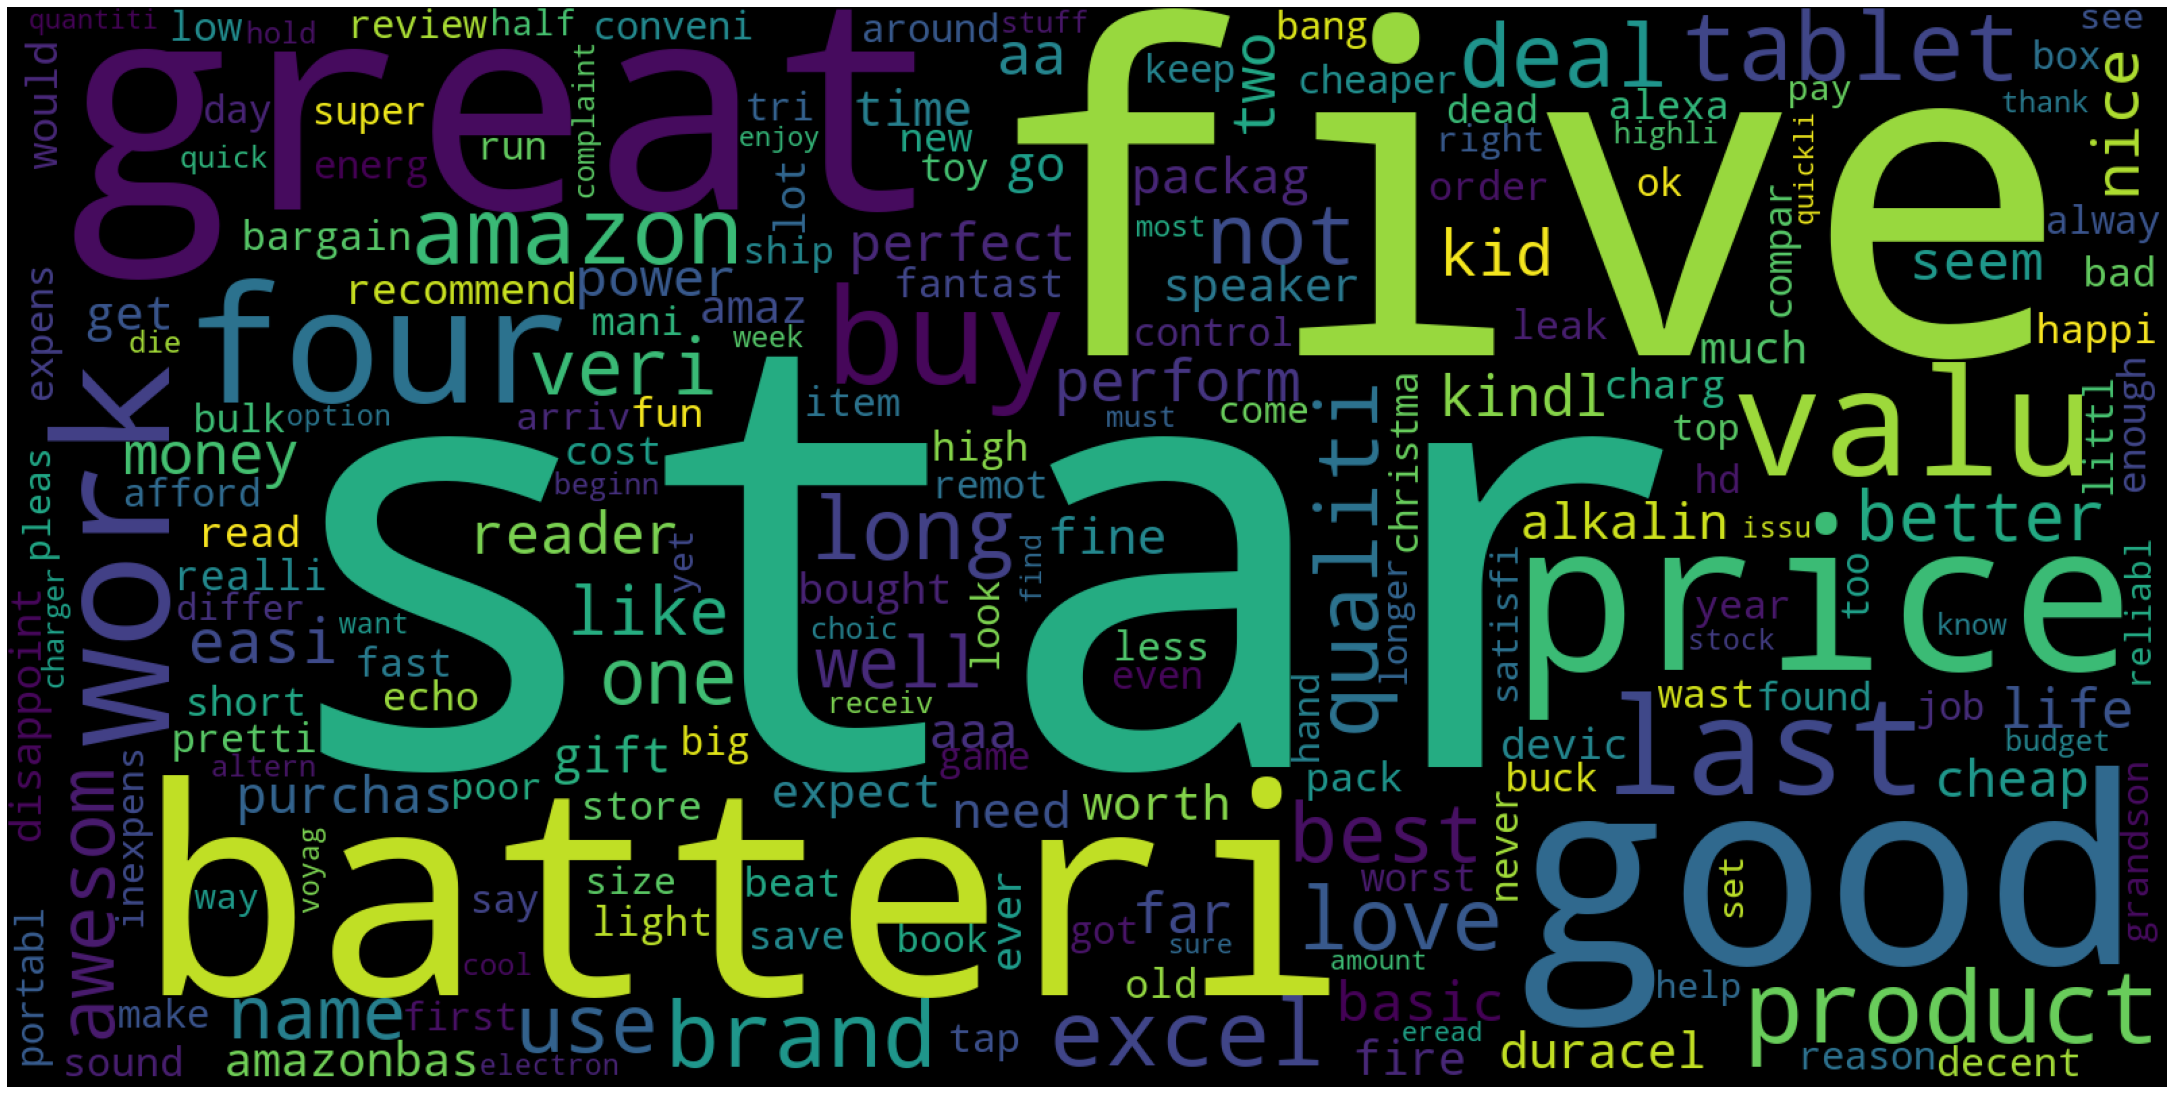

In [37]:
from wordcloud import WordCloud
tup = dict(pos_set.items())
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

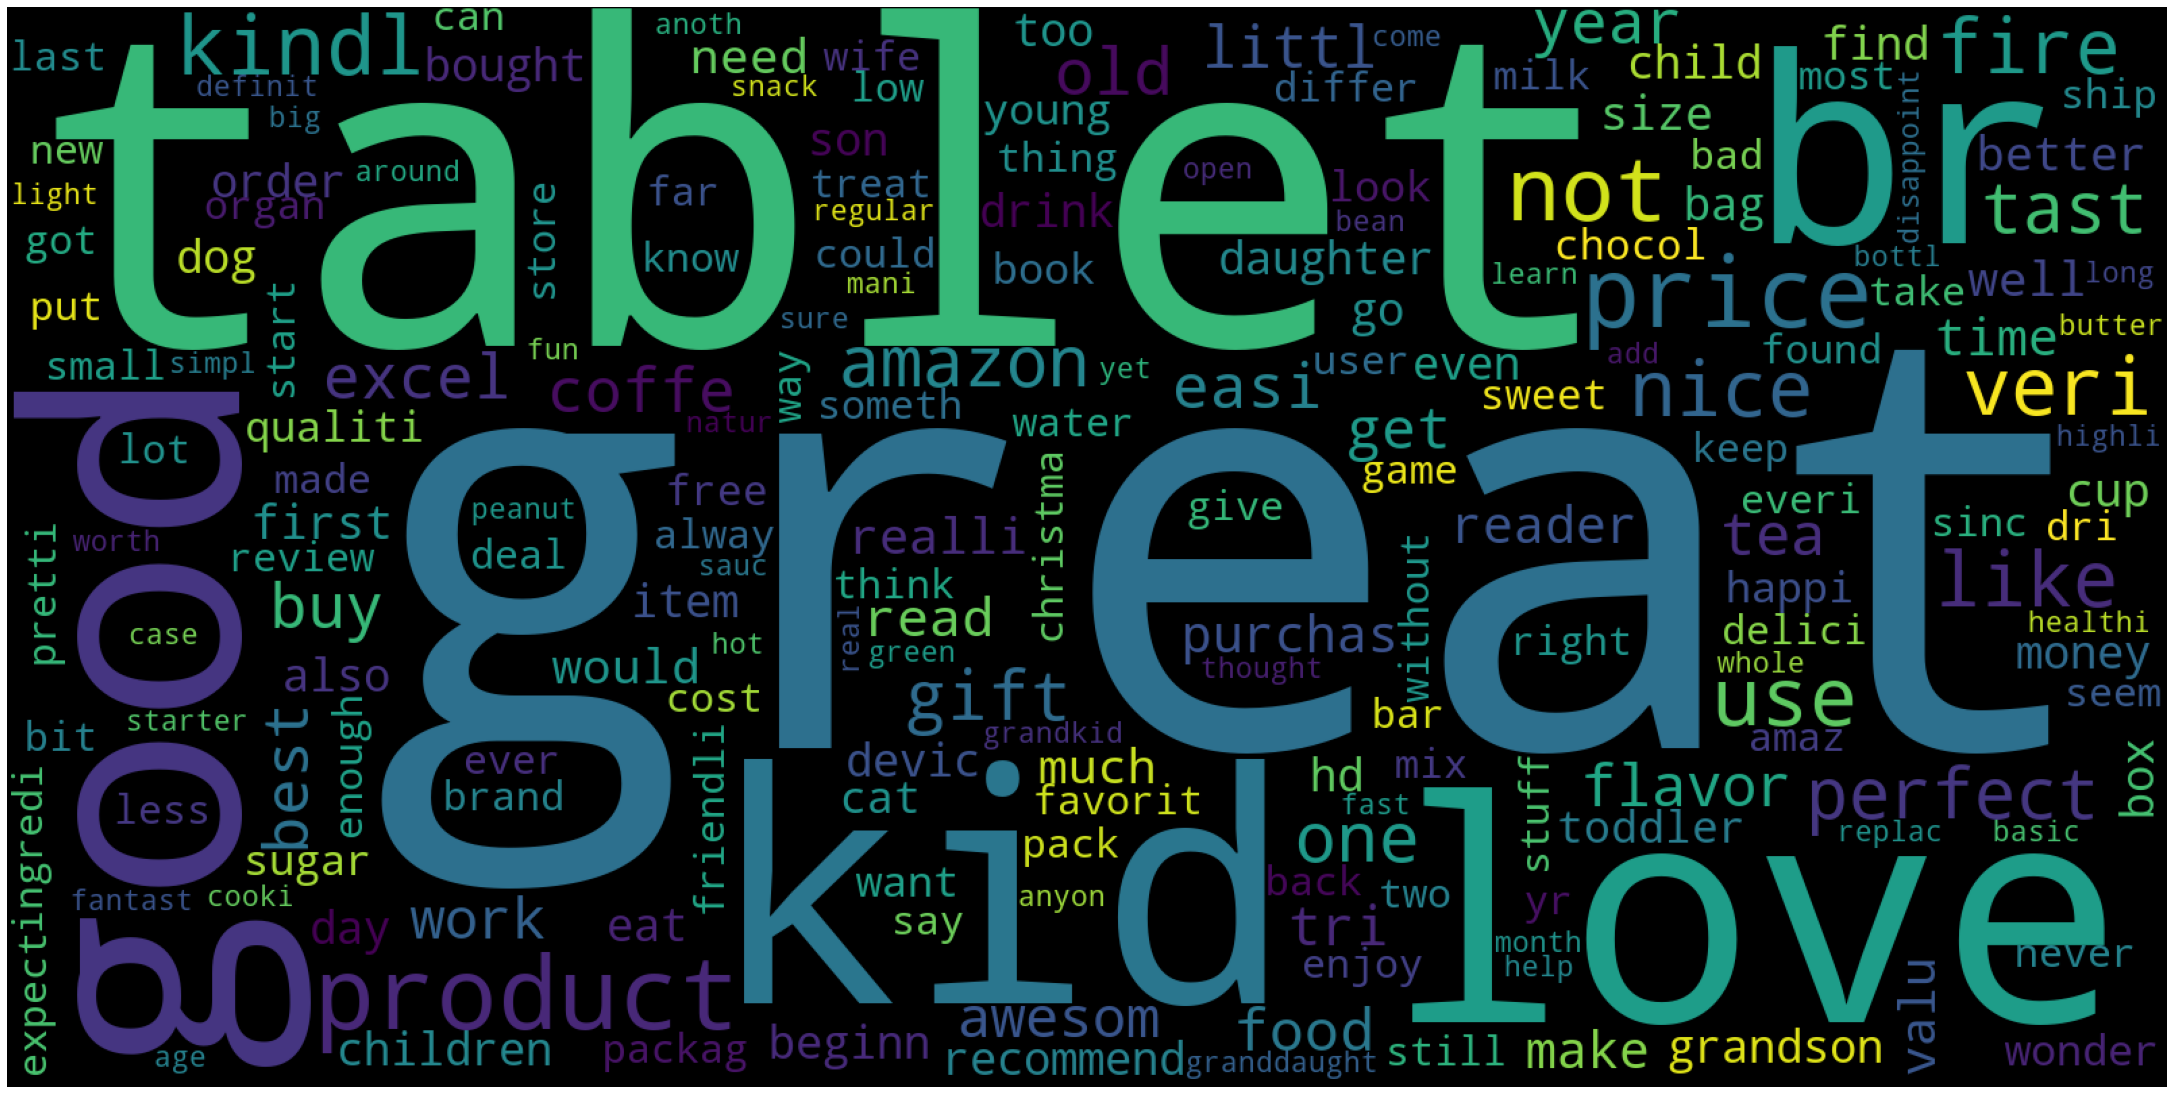

In [38]:
from wordcloud import WordCloud
tup = dict(neg_set.items())
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

In [39]:
y = data_sampled['Score']
X = data_sampled['Text']

In [40]:
## Using Tfidf Vectorizer to transform the text data
tf = TfidfVectorizer(ngram_range=(1,3),min_df = 0.05,max_features=20000)
tf_text= tf.fit_transform(X).toarray()

In [41]:
tf_text.shape

(28182, 171)

In [42]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test  = train_test_split(tf_text,y,test_size=0.3,random_state=0)

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluation Metrics

In [44]:
rf.score(X_train,y_train)

0.9830688903533229

In [45]:
rf.score(X_test,y_test)

0.8011827321111769

In [46]:
rf_pred = rf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
print(classification_report(y_test,rf_pred))
print(confusion_matrix(y_test,rf_pred))
print(roc_auc_score(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      4238
           1       0.83      0.75      0.79      4217

    accuracy                           0.80      8455
   macro avg       0.80      0.80      0.80      8455
weighted avg       0.80      0.80      0.80      8455

[[3603  635]
 [1046 3171]]
0.8010607696683337


In [47]:
from sklearn.model_selection import cross_val_score
cs = cross_val_score(rf,tf_text,y,cv=10)

In [48]:
 cs

array([0.47392692, 0.79035119, 0.8133428 , 0.82185947, 0.8087296 ,
       0.81227821, 0.80731015, 0.8151171 , 0.81298793, 0.82576295])

In [49]:
cs.mean()

0.7781666331400708

##Checking the Performance of different models

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [51]:
lr = LogisticRegression()
mnb = MultinomialNB()
lsvc = LinearSVC()
dt = DecisionTreeClassifier()
gbdt = GradientBoostingClassifier()
knn = KNeighborsClassifier()
xgb = XGBClassifier()

In [52]:
models = list([lr,mnb,lsvc,dt,gbdt,knn,xgb])

In [53]:
%%time
model_score = []
model_roc_auc = []
for i in models:
  i.fit(X_train,y_train)
  i_pred = i.predict(X_test)
  model_score.append(i.score(X_test,y_test))
  model_roc_auc.append(roc_auc_score(y_test,i_pred))

CPU times: user 2min 47s, sys: 428 ms, total: 2min 48s
Wall time: 2min 47s


In [54]:
model_score

[0.78214074512123,
 0.7705499704316973,
 0.7826138379657007,
 0.7180366646954465,
 0.7699586043761089,
 0.7018332347723241,
 0.7726788882318155]

In [55]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

## Evaluation Metrics

In [56]:
print(classifier.score(X_train,y_train))
print(classifier.score(X_test,y_test))

0.7679322755614133
0.7705499704316973


In [57]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4238
           1       0.79      0.74      0.76      4217

    accuracy                           0.77      8455
   macro avg       0.77      0.77      0.77      8455
weighted avg       0.77      0.77      0.77      8455

[[3400  838]
 [1102 3115]]
0.7704710019435255


## Hyperparameter Tuning Using GridSearhCV

In [58]:
%%time
from sklearn.model_selection import GridSearchCV
params = {'alpha':[10**-5,10**-3, 10**-1,1,10**1]}
gs = GridSearchCV(classifier,params,scoring='roc_auc',cv=5)
gs.fit(X_train,y_train)

CPU times: user 885 ms, sys: 504 ms, total: 1.39 s
Wall time: 718 ms


In [59]:
gs.best_score_

0.8417650873909212

In [60]:
gs.best_params_

{'alpha': 10}

In [62]:
gs_cls = MultinomialNB(alpha=10)
gs_cls.fit(X_train,y_train)
print(gs_cls.score(X_train,y_train))
print(gs_cls.score(X_test,y_test))

0.7683885030668627
0.7699586043761089


In [63]:
predictions = gs_cls.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4238
           1       0.79      0.74      0.76      4217

    accuracy                           0.77      8455
   macro avg       0.77      0.77      0.77      8455
weighted avg       0.77      0.77      0.77      8455

[[3387  851]
 [1094 3123]]
0.7698858012295006


In [64]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss='log',penalty='l2')
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [65]:
print(classifier.score(X_train,y_train))
print(classifier.score(X_test,y_test))

0.7817204846149947
0.7757539917208752


In [66]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      4238
           1       0.75      0.83      0.79      4217

    accuracy                           0.78      8455
   macro avg       0.78      0.78      0.78      8455
weighted avg       0.78      0.78      0.78      8455

[[3041 1197]
 [ 699 3518]]
0.775898901533748


In [67]:
%%time
from sklearn.model_selection import GridSearchCV
params = {'alpha':[10**-5,10**-3, 10**-1,1,10**1]}
gs = GridSearchCV(classifier,params,scoring='precision',cv=10)
gs.fit(X_train,y_train)

CPU times: user 16 s, sys: 4.86 s, total: 20.8 s
Wall time: 15.2 s


In [69]:
gs.best_score_

0.8077634508273654

In [70]:
gs.best_params_

{'alpha': 1e-05}

In [72]:
sgd_gs = SGDClassifier(penalty='l2',loss='log',alpha=1e-05)
sgd_gs.fit(X_train,y_train)
predictions = sgd_gs.predict(X_test)

In [73]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.55      0.68      4238
           1       0.67      0.92      0.77      4217

    accuracy                           0.73      8455
   macro avg       0.77      0.73      0.73      8455
weighted avg       0.77      0.73      0.73      8455

[[2345 1893]
 [ 355 3862]]
0.7345719862624853


In [77]:
def preprocessing(a):
      a = re.sub('[^a-zA-Z]',' ',a)
      a = a.lower()
      a = a.split()
    
      message = [ps.stem(word) for word in a if not word in stop_words and len(word) >1]
      message = ' '.join(message)
      print(message)
      
      transformed = tf.transform([message])
      return transformed

In [82]:
print(sgd_gs.predict(preprocessing('This is very  expensive product and is not upto the expectations')))

veri expens product not upto expect
[0]


## Saving the Model

In [83]:
import pickle
pickle.dump(gs_cls,open('sgd_gs.pkl','wb'))

In [85]:
pickle.dump(tf,open('tf_sentimental.pkl','wb'))